# Setup

In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.models as models
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, Subset
import os
import matplotlib.pyplot as plt
import nibabel as nib
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import cv2

In [ ]:
"""
from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/archive'
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\ndataset_path = '/content/drive/MyDrive/archive'\n"

In [ ]:
!git clone https://github.com/facebookresearch/moco.git
%cd moco

Cloning into 'moco'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 112 (delta 41), reused 64 (delta 34), pack-reused 38
Receiving objects: 100% (112/112), 65.83 KiB | 1.04 MiB/s, done.
Resolving deltas: 100% (51/51), done.
/content/moco


# Data preprocessing

In [ ]:
class BraTSDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.path))

    def __getitem__(self, index):
        folder = os.listdir(self.path)[index]
        folder_path = self.path + '/' + folder + '/' + folder
        image = nib.load(folder_path + '_flair.nii').get_fdata()[:, :, 77]
        mask = nib.load(folder_path + '_seg.nii').get_fdata()[:, :, 77]

        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        image = image.astype(np.float32)
        image = Image.fromarray((image * 255).astype(np.uint8))
        image = image.convert('RGB')

        if self.transform:
            transform_1 = self.transform(image)
            transform_2 = self.transform(image)

            return (transform_1, transform_2), mask

        else:
            return transforms.Compose([transforms.ToTensor()])(image), transforms.Compose([transforms.ToTensor()])(mask)

In [ ]:
class ChestXrayDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.path + '/image')) -1

    def __getitem__(self, index):
        image = Image.open(self.path + '/image/cxrimage_' + str(index) + '.png')
        mask = Image.open(self.path + '/mask/cxrmask_' + str(index) + '.jpeg')

        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        image = image.astype(np.float32)
        image = Image.fromarray((image * 255).astype(np.uint8))
        image = image.convert('RGB')

        if self.transform:
            transform_1 = transforms.functional.crop(self.transform(image), 75, 75, 362, 362)
            transform_2 = transforms.functional.crop(self.transform(image), 75, 75, 362, 362)

            return (transform_1, transform_2), np.array(mask.crop((75, 75, 362, 362)))[0]

        else:
            return transforms.Compose([transforms.ToTensor()])(image), transforms.Compose([transforms.ToTensor()])(mask)

In [ ]:
class GIDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.path + '/images'))

    def __getitem__(self, index):
        image = Image.open(self.path + '/images/image_' + str(index) + '.jpg')
        mask = Image.open(self.path + '/masks/mask_' + str(index) + '.jpg')

        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        image = image.astype(np.float32)
        image = Image.fromarray((image * 255).astype(np.uint8))
        image = image.convert('RGB')

        if self.transform:
            transform_1 = transforms.functional.crop(self.transform(image), 75, 75, 362, 362)
            transform_2 = transforms.functional.crop(self.transform(image), 75, 75, 362, 362)

            return (transform_1, transform_2), np.array(mask.crop((75, 75, 362, 362)))[0]

        else:
            return transforms.Compose([transforms.ToTensor()])(image), transforms.Compose([transforms.ToTensor()])(mask)

In [ ]:
def calculate_mean_std(dataset):
    means = []
    stds = []

    for i in tqdm(range(len(dataset))):
        image, _ = dataset[i]
        image = image.astype(np.float32)
        means.append(np.mean(image))
        stds.append(np.std(image))

    mean = np.mean(means)
    std = np.mean(stds)
    return mean, std

mean = 0.1276496946811676
std = 0.21015071868896484

In [ ]:
transform = transforms.Compose([
    transforms.RandomApply([transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0))], p=0.3),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.5),
    transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.3),
    transforms.RandomApply([transforms.RandomVerticalFlip()], p=0.3),
    transforms.RandomApply([transforms.RandomRotation(degrees=(0, 360))], p=0.3),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=10)], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [ ]:
train_dataset = BraTSDataset('/content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData', transform)
print(train_dataset[0])

((tensor([[[-0.6074, -0.6074, -0.6074,  ..., -0.6074, -0.6074, -0.6074],
         [-0.6074, -0.6074, -0.6074,  ..., -0.6074, -0.6074, -0.6074],
         [-0.6074, -0.6074, -0.6074,  ..., -0.6074, -0.6074, -0.6074],
         ...,
         [-0.6074, -0.6074, -0.6074,  ..., -0.6074, -0.6074, -0.6074],
         [-0.6074, -0.6074, -0.6074,  ..., -0.6074, -0.6074, -0.6074],
         [-0.6074, -0.6074, -0.6074,  ..., -0.6074, -0.6074, -0.6074]],

        [[-0.6074, -0.6074, -0.6074,  ..., -0.6074, -0.6074, -0.6074],
         [-0.6074, -0.6074, -0.6074,  ..., -0.6074, -0.6074, -0.6074],
         [-0.6074, -0.6074, -0.6074,  ..., -0.6074, -0.6074, -0.6074],
         ...,
         [-0.6074, -0.6074, -0.6074,  ..., -0.6074, -0.6074, -0.6074],
         [-0.6074, -0.6074, -0.6074,  ..., -0.6074, -0.6074, -0.6074],
         [-0.6074, -0.6074, -0.6074,  ..., -0.6074, -0.6074, -0.6074]],

        [[-0.6074, -0.6074, -0.6074,  ..., -0.6074, -0.6074, -0.6074],
         [-0.6074, -0.6074, -0.6074,  ..., 

# Pretrained MoCo

This section is taken from here: https://github.com/facebookresearch/moco/blob/main/moco/builder.py

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

import torch
import torch.nn as nn


class MoCo(nn.Module):
    """
    Build a MoCo model with: a query encoder, a key encoder, and a queue
    https://arxiv.org/abs/1911.05722
    """

    def __init__(self, base_encoder, dim=128, K=65536, m=0.999, T=0.07, mlp=False):
        """
        dim: feature dimension (default: 128)
        K: queue size; number of negative keys (default: 65536)
        m: moco momentum of updating key encoder (default: 0.999)
        T: softmax temperature (default: 0.07)
        """
        super(MoCo, self).__init__()

        self.K = K
        self.m = m
        self.T = T

        # create the encoders
        # num_classes is the output fc dimension
        self.encoder_q = base_encoder(num_classes=dim)
        self.encoder_k = base_encoder(num_classes=dim)

        if mlp:  # hack: brute-force replacement
            dim_mlp = self.encoder_q.fc.weight.shape[1]
            self.encoder_q.fc = nn.Sequential(
                nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.encoder_q.fc
            )
            self.encoder_k.fc = nn.Sequential(
                nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.encoder_k.fc
            )

        for param_q, param_k in zip(
            self.encoder_q.parameters(), self.encoder_k.parameters()
        ):
            param_k.data.copy_(param_q.data)  # initialize
            param_k.requires_grad = False  # not update by gradient

        # create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """
        Momentum update of the key encoder
        """
        for param_q, param_k in zip(
            self.encoder_q.parameters(), self.encoder_k.parameters()
        ):
            param_k.data = param_k.data * self.m + param_q.data * (1.0 - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        # gather keys before updating queue
        keys = concat_all_gather(keys)

        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)
        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr : ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def _batch_shuffle_ddp(self, x):
        """
        Batch shuffle, for making use of BatchNorm.
        *** Only support DistributedDataParallel (DDP) model. ***
        """
        # gather from all gpus
        batch_size_this = x.shape[0]
        x_gather = concat_all_gather(x)
        batch_size_all = x_gather.shape[0]

        num_gpus = batch_size_all // batch_size_this

        # random shuffle index
        idx_shuffle = torch.randperm(batch_size_all).cuda()

        # broadcast to all gpus
        #torch.distributed.broadcast(idx_shuffle, src=0)

        # index for restoring
        idx_unshuffle = torch.argsort(idx_shuffle)

        # shuffled index for this gpu
        #gpu_idx = torch.distributed.get_rank()
        gpu_idx = torch.cuda.current_device()
        idx_this = idx_shuffle.view(num_gpus, -1)[gpu_idx]

        return x_gather[idx_this], idx_unshuffle

    @torch.no_grad()
    def _batch_unshuffle_ddp(self, x, idx_unshuffle):
        """
        Undo batch shuffle.
        *** Only support DistributedDataParallel (DDP) model. ***
        """
        # gather from all gpus
        batch_size_this = x.shape[0]
        x_gather = concat_all_gather(x)
        batch_size_all = x_gather.shape[0]

        num_gpus = batch_size_all // batch_size_this

        # restored index for this gpu
        #gpu_idx = torch.distributed.get_rank()
        gpu_idx = torch.cuda.current_device()
        idx_this = idx_unshuffle.view(num_gpus, -1)[gpu_idx]

        return x_gather[idx_this]

    def forward(self, im_q, im_k):
        """
        Input:
            im_q: a batch of query images
            im_k: a batch of key images
        Output:
            logits, targets
        """

        # compute query features
        q = self.encoder_q(im_q)  # queries: NxC
        q = nn.functional.normalize(q, dim=1)

        # compute key features
        with torch.no_grad():  # no gradient to keys
            self._momentum_update_key_encoder()  # update the key encoder
            """
            # shuffle for making use of BN
            im_k, idx_unshuffle = self._batch_shuffle_ddp(im_k)

            k = self.encoder_k(im_k)  # keys: NxC
            k = nn.functional.normalize(k, dim=1)

            # undo shuffle
            k = self._batch_unshuffle_ddp(k, idx_unshuffle)
            """
            k = self.encoder_k(im_k)
            k = nn.functional.normalize(k, dim=1)

        # compute logits
        # Einstein sum is more intuitive
        # positive logits: Nx1
        l_pos = torch.einsum("nc,nc->n", [q, k]).unsqueeze(-1)
        # negative logits: NxK
        l_neg = torch.einsum("nc,ck->nk", [q, self.queue.clone().detach()])

        # logits: Nx(1+K)
        logits = torch.cat([l_pos, l_neg], dim=1)

        # apply temperature
        logits /= self.T

        # labels: positive key indicators
        labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()

        # dequeue and enqueue
        #self._dequeue_and_enqueue(k)

        return logits, labels


# utils
@torch.no_grad()
def concat_all_gather(tensor):
    """
    Performs all_gather operation on the provided tensors.
    *** Warning ***: torch.distributed.all_gather has no gradient.
    """
    tensors_gather = [
        torch.ones_like(tensor) for _ in range(torch.distributed.get_world_size())
    ]
    torch.distributed.all_gather(tensors_gather, tensor, async_op=False)

    output = torch.cat(tensors_gather, dim=0)
    return output

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

import random

from PIL import ImageFilter


class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]


class GaussianBlur:
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[0.1, 2.0]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x

In [ ]:
model_names = sorted(
    name
    for name in models.__dict__
    if name.islower() and not name.startswith("__") and callable(models.__dict__[name])
)

arch = "resnet50"
workers = 2
epochs = 100
batch_size = 64
learning_rate = 0.01
momentum = 0.9
weight_decay = 1e-4
print_freq = 10
resume = ""  # path to the latest checkpoint (default: none)
world_size = 1
rank = 1
dist_url = "tcp://224.66.41.62:23456"
dist_backend = "nccl"
seed = None  # seed for initializing training
if torch.cuda.is_available():
    gpu = 0
    print("CUDA is available. Using GPU.")
else:
    gpu = None
    print("CUDA is not available. Using CPU.")
moco_dim = 128
moco_k = 65536
moco_m = 0.999
moco_t = 0.07
mlp = False  # use mlp head
aug_plus = False  # use moco v2 data augmentation
cos = False  # use cosine lr schedule
multiprocessing_distributed = False
pretrained = True
distributed = False

CUDA is available. Using GPU.


The following code fine tunes the pretrained MoCo from Meta on the BraTS dataset.

In [ ]:
#!/usr/bin/env python

# Copyright (c) Meta Platforms, Inc. and affiliates.

# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

import argparse
import builtins
import math
import os
import random
import shutil
import time
import warnings

import torch
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

loss_values = []

def main():
    global arch, workers, epochs, batch_size, learning_rate, momentum, weight_decay, print_freq, resume, world_size, rank, dist_url, dist_backend, seed, gpu, moco_dim, moco_k, moco_m, moco_t, mlp, aug_plus, cos

    mp.spawn(main_worker, args=(0), nprocs=world_size, join=False)

    if seed is not None:
        random.seed(seed)
        torch.manual_seed(seed)
        cudnn.deterministic = True
        warnings.warn(
            "You have chosen to seed training. "
            "This will turn on the CUDNN deterministic setting, "
            "which can slow down your training considerably! "
            "You may see unexpected behavior when restarting "
            "from checkpoints."
        )

    if gpu is not None:
        warnings.warn(
            "You have chosen a specific GPU. This will completely "
            "disable data parallelism."
        )

    if dist_url == "env://" and world_size == -1:
        world_size = int(os.environ["WORLD_SIZE"])

    distributed = world_size > 1 or multiprocessing_distributed

    ngpus_per_node = torch.cuda.device_count()
    if multiprocessing_distributed:
        # Since we have ngpus_per_node processes per node, the total world_size
        # needs to be adjusted accordingly
        world_size = ngpus_per_node * world_size
        # Use torch.multiprocessing.spawn to launch distributed processes: the
        # main_worker process function
        mp.spawn(main_worker, nprocs=ngpus_per_node, args=(ngpus_per_node))
    else:
        # Simply call main_worker function
        main_worker(gpu, ngpus_per_node)


def main_worker(gpu, ngpus_per_node):
    global arch, workers, epochs, batch_size, learning_rate, momentum, weight_decay, print_freq, resume, world_size, rank, dist_url, dist_backend, seed, moco_dim, moco_k, moco_m, moco_t, mlp, aug_plus, cos

    # suppress printing if not master
    if multiprocessing_distributed and gpu != 0:

        def print_pass(*args):
            pass

        builtins.print = print_pass

    if gpu is not None:
        print("Use GPU: {} for training".format(gpu))

    if distributed:
        if dist_url == "env://" and rank == -1:
            rank = int(os.environ["RANK"])
        if multiprocessing_distributed:
            # For multiprocessing distributed training, rank needs to be the
            # global rank among all the processes
            rank = rank * ngpus_per_node + gpu
        dist.init_process_group(
            backend=dist_backend,
            init_method=dist_url,
            world_size=world_size,
            rank=rank,
        )
    # create model
    print("=> creating model '{}'".format(arch))
    model = MoCo(
        models.__dict__[arch],
        moco_dim,
        moco_k,
        moco_m,
        moco_t,
        mlp,
    )

    if distributed:
        # For multiprocessing distributed, DistributedDataParallel constructor
        # should always set the single device scope, otherwise,
        # DistributedDataParallel will use all available devices.
        if gpu is not None:
            torch.cuda.set_device(gpu)
            model.cuda(gpu)
            # When using a single GPU per process and per
            # DistributedDataParallel, we need to divide the batch size
            # ourselves based on the total number of GPUs we have
            batch_size = int(batch_size / ngpus_per_node)
            workers = int((workers + ngpus_per_node - 1) / ngpus_per_node)
            model = torch.nn.parallel.DistributedDataParallel(
                model, device_ids=[gpu]
            )
        else:
            model.cuda()
            # DistributedDataParallel will divide and allocate batch_size to all
            # available GPUs if device_ids are not set
            model = torch.nn.parallel.DistributedDataParallel(model)
    elif gpu is not None:
        torch.cuda.set_device(gpu)
        model = model.cuda(gpu)
        # comment out the following line for debugging
        #raise NotImplementedError("Only DistributedDataParallel is supported.")
    else:
        # AllGather implementation (batch shuffle, queue update, etc.) in
        # this code only supports DistributedDataParallel.
        raise NotImplementedError("Only DistributedDataParallel is supported.")

    # define loss function (criterion) and optimizer
    criterion = nn.CrossEntropyLoss().cuda(gpu)

    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=learning_rate,
        momentum=momentum,
        weight_decay=weight_decay,
    )

    # optionally resume from a checkpoint
    if resume:
        if os.path.isfile(resume):
            print("=> loading checkpoint '{}'".format(resume))
            if gpu is None:
                checkpoint = torch.load(resume)
            else:
                # Map model to be loaded to specified single gpu.
                loc = "cuda:{}".format(gpu)
                checkpoint = torch.load(resume, map_location=loc)
            start_epoch = checkpoint["epoch"]
            model.load_state_dict(checkpoint["state_dict"])
            optimizer.load_state_dict(checkpoint["optimizer"])
            print(
                "=> loaded checkpoint '{}' (epoch {})".format(
                    resume, checkpoint["epoch"]
                )
            )
        else:
            print("=> no checkpoint found at '{}'".format(resume))

    cudnn.benchmark = True

    # Data loading code
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )
    if aug_plus:
        # MoCo v2's aug: similar to SimCLR https://arxiv.org/abs/2002.05709
        augmentation = [
            transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),
            transforms.RandomApply(
                [transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8  # not strengthened
            ),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([GaussianBlur([0.1, 2.0])], p=0.5),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]
    else:
        # MoCo v1's aug: the same as InstDisc https://arxiv.org/abs/1805.01978
        augmentation = [
            transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),
            transforms.RandomGrayscale(p=0.2),
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]

    train_dataset = BraTSDataset('/content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData', transform)

    if distributed:
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
    else:
        train_sampler = None

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,  # Shuffle the dataset
        num_workers=workers,
        pin_memory=True,
        drop_last=True,
    )

    for epoch in range(0, epochs):
        if distributed:
            train_sampler.set_epoch(epoch)
        adjust_learning_rate(optimizer, epoch)

        # train for one epoch
        train(train_loader, model, criterion, optimizer, epoch)

        if not multiprocessing_distributed or (
            multiprocessing_distributed and rank % ngpus_per_node == 0
        ):
            save_checkpoint(
                {
                    "epoch": epoch + 1,
                    "arch": arch,
                    "state_dict": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                },
                is_best=False,
                filename="checkpoint_{:04d}.pth.tar".format(epoch),
            )

def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter("Time", ":6.3f")
    data_time = AverageMeter("Data", ":6.3f")
    losses = AverageMeter("Loss", ":.4e")
    top1 = AverageMeter("Acc@1", ":6.2f")
    top5 = AverageMeter("Acc@5", ":6.2f")
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top5],
        prefix="Epoch: [{}]".format(epoch),
    )

    # switch to train mode
    model.train()

    end = time.time()
    for i, (images, _) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if gpu is not None:
            images[0] = images[0].cuda(gpu, non_blocking=True)
            images[1] = images[1].cuda(gpu, non_blocking=True)

        # compute output
        output, target = model(im_q=images[0], im_k=images[1])
        loss = criterion(output, target)
        loss_values.append(loss)

        # acc1/acc5 are (K+1)-way contrast classifier accuracy
        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images[0].size(0))
        top1.update(acc1[0], images[0].size(0))
        top5.update(acc5[0], images[0].size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            progress.display(i)


def save_checkpoint(state, is_best, filename="checkpoint.pth.tar"):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, "model_best.pth.tar")


class AverageMeter:

    def __init__(self, name, fmt=":f"):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = "{name} {val" + self.fmt + "} ({avg" + self.fmt + "})"
        return fmtstr.format(**self.__dict__)


class ProgressMeter:
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print("\t".join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = "{:" + str(num_digits) + "d}"
        return "[" + fmt + "/" + fmt.format(num_batches) + "]"


def adjust_learning_rate(optimizer, epoch):
    global learning_rate
    lr = learning_rate
    schedule = [50, 100, 150]
    if cos:  # cosine lr schedule
        lr *= 0.5 * (1.0 + math.cos(math.pi * epoch / epochs))
    else:  # stepwise lr schedule
        for milestone in schedule:
            lr *= 0.1 if epoch >= milestone else 1.0
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


if __name__ == "__main__":
    main()

'\nimport argparse\nimport builtins\nimport math\nimport os\nimport random\nimport shutil\nimport time\nimport warnings\n\nimport torch\nimport torch.backends.cudnn as cudnn\nimport torch.distributed as dist\nimport torch.multiprocessing as mp\nimport torch.nn as nn\nimport torch.nn.parallel\nimport torch.optim\nimport torch.utils.data\nimport torch.utils.data.distributed\nimport torchvision.datasets as datasets\nimport torchvision.models as models\nimport torchvision.transforms as transforms\n\nloss_values = []\n\ndef main():\n    global arch, workers, epochs, batch_size, learning_rate, momentum, weight_decay, print_freq, resume, world_size, rank, dist_url, dist_backend, seed, gpu, moco_dim, moco_k, moco_m, moco_t, mlp, aug_plus, cos\n\n    mp.spawn(main_worker, args=(0), nprocs=world_size, join=False)\n\n    if seed is not None:\n        random.seed(seed)\n        torch.manual_seed(seed)\n        cudnn.deterministic = True\n        warnings.warn(\n            "You have chosen to seed

# Downstream task (image segmentation)

In [ ]:
class ModifiedEncoder(nn.Module):
    def __init__(self, encoder_q):
        super(ModifiedEncoder, self).__init__()
        self.initial_layers = nn.Sequential(
            encoder_q.conv1,
            encoder_q.bn1,
            encoder_q.relu,
            encoder_q.maxpool
        )
        self.layer1 = encoder_q.layer1
        self.layer2 = encoder_q.layer2
        self.layer3 = encoder_q.layer3
        self.layer4 = encoder_q.layer4

    def forward(self, x):
        x0 = self.initial_layers(x)
        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        return x0, x1, x2, x3, x4

def double_conv_2d(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class UNet2D(nn.Module):
    def __init__(self, modified_encoder, num_classes):
        super(UNet2D, self).__init__()

        self.encoder = modified_encoder

        self.pool = nn.MaxPool2d(2)
        self.upconv3 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose2d(512, 128, kernel_size=2, stride=2)

        self.dec3 = double_conv_2d(2048, 1024)
        self.dec2 = double_conv_2d(1024, 512)
        self.dec1 = double_conv_2d(128 + 256, 128)

        self.out_conv = nn.Conv2d(128, num_classes, kernel_size=1)

    def forward(self, x):

        x0, x1, x2, x3, x4 = self.encoder(x)

        dec3 = self.dec3(torch.cat([F.interpolate(self.upconv3(x4), size=
         (x3.size(2), x3.size(3)), mode='bilinear', align_corners=True), x3],
                                   dim=1))
        dec2 = self.dec2(torch.cat([self.upconv2(dec3), x2], dim=1))
        dec1 = self.dec1(torch.cat([self.upconv1(dec2), x1], dim=1))

        output = F.interpolate(dec1, size=(128, 128), mode='bilinear',
                               align_corners=True)

        return self.out_conv(output)

In [ ]:
train_dataset = BraTSDataset('/content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData')
train_subset = Subset(train_dataset, range(10))
validation_dataset = BraTSDataset('/content/drive/MyDrive/archive/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData')

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=True
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=True
)

In [ ]:
num_epochs = 200
num_classes = 4

def dice_loss(pred, target, batch, epsilon=1e-6):

    probability1 = pred.squeeze().cpu().detach().numpy()
    targets1 = target.squeeze().cpu().detach().numpy()

    if batch % 5 == 0:
        fig, axs = plt.subplots(2, 4, figsize=(15, 8))

        axs[0][0].set_title('Class 1 (Predicted)')
        axs[0][0].imshow(probability1[0][0])
        axs[1][0].set_title('Class 1 (True)')
        axs[1][0].imshow(targets1[0][0])

        axs[0][1].set_title('Class 2 (Predicted)')
        axs[0][1].imshow(probability1[0][1])
        axs[1][1].set_title('Class 2 (True)')
        axs[1][1].imshow(targets1[0][1])

        axs[0][2].set_title('Class 3 (Predicted)')
        axs[0][2].imshow(probability1[0][2])
        axs[1][2].set_title('Class 3 (True)')
        axs[1][2].imshow(targets1[0][2])

        axs[0][3].set_title('Class 4 (Predicted)')
        axs[0][3].imshow(probability1[0][3])
        axs[1][3].set_title('Class 4 (True)')
        axs[1][3].imshow(targets1[0][3])

        plt.show()

    pred = F.softmax(pred, dim=0)

    total_loss = 0.0
    weights = [1, 1, 1, 1]

    for class_id in range(pred.size(1)):
        pred_flat = pred[:, class_id, ...].contiguous().view(-1)
        target_flat = target[:, class_id, ...].contiguous().view(-1)

        TP = (pred_flat * target_flat).sum()
        FP = (pred_flat * (1 - target_flat)).sum()
        FN = ((1 - pred_flat) * target_flat).sum()

        dice_score = (2 * TP + epsilon) / (2 * TP + FP + FN + epsilon)

        dice_loss_class = 1 - dice_score
        total_loss += dice_loss_class * weights[class_id]

    return total_loss / sum(weights)

def focal_loss(pred, target):

      alpha=0.25
      gamma=2.0

      ce_loss = torch.nn.functional.cross_entropy(pred, target, reduction='none')
      pt = torch.exp(-ce_loss)
      focal_loss = (alpha * (1-pt)**gamma * ce_loss).mean()

      return focal_loss

def metrics_per_classes(probabilities: np.ndarray, truth: np.ndarray, threshold: float = 0.5,
                        eps: float = 1e-9, classes: list = ['WT', 'TC', 'ET', 'BG']) -> np.ndarray:

    metrics_sum = {'Dice': 0, 'IoU': 0, 'Specificity': 0, 'Sensitivity': 0}
    num_classes = len(classes)
    total_samples = 0

    predictions = (probabilities >= threshold).float()
    truth = truth.float()

    for i in range(probabilities.shape[0]):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum() - intersection
            true_negative = ((~truth_.bool()) & (~prediction.bool())).sum()
            false_positive = ((~truth_.bool()) & prediction.bool()).sum()
            false_negative = (truth_.bool() & (~prediction.bool())).sum()

            dice = (2.0 * intersection + eps) / (union + intersection + eps)
            iou = (intersection + eps) / (union + eps)
            specificity = (true_negative + eps) / (true_negative + false_positive + eps)
            sensitivity = (intersection + eps) / (intersection + false_negative + eps)

            metrics_sum['Dice'] += dice.item()
            metrics_sum['IoU'] += iou.item()
            metrics_sum['Specificity'] += specificity.item()
            metrics_sum['Sensitivity'] += sensitivity.item()
            total_samples += 1

    global_metrics = {metric: total / total_samples for metric, total in metrics_sum.items()}

    return global_metrics

def evaluation_metrics(pred, target, epsilon=1e-6):
    dice_list = []
    iou_list = []
    sensitivity_list = []
    specificity_list = []

    pred_softmax = F.softmax(pred, dim=0)
    pred_argmax = torch.argmax(pred_softmax, dim=0)

    for class_id in range(num_classes):
        pred_class = (pred_argmax == class_id).float()
        target_class = (target == class_id).float()

        TP = (pred_class * target_class).sum().item()
        TN = ((1 - pred_class) * (1 - target_class)).sum().item()
        FP = (pred_class * (1 - target_class)).sum().item()
        FN = ((1 - pred_class) * target_class).sum().item()

        dice_score = (2 * TP) / (2 * TP + FP + FN + epsilon)
        iou_score = (TP) / (TP + FP + FN + epsilon)
        sensitivity_score = (TP) / (TP + FN + epsilon)
        specificity_score = (TN) / (TN + FP + epsilon)

        dice_list.append(dice_score)
        iou_list.append(iou_score)
        sensitivity_list.append(sensitivity_score)
        specificity_list.append(specificity_score)

    dice = sum(dice_list) / len(dice_list)
    iou = sum(iou_list) / len(iou_list)
    sensitivity = sum(sensitivity_list) / len(sensitivity_list)
    specificity = sum(specificity_list) / len(specificity_list)

    return dice, iou, sensitivity, specificity

class PolyLR(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, num_epochs, power=0.9, last_epoch=-1):
        self.num_epochs = num_epochs
        self.power = power
        super(PolyLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        factor = (1 - self.last_epoch / self.num_epochs) ** self.power
        return [base_lr * factor for base_lr in self.base_lrs]

moco_model = MoCo(models.__dict__[arch], dim=128, K=65536, m=0.999, T=0.07, mlp=False)
checkpoint = torch.load('/content/drive/MyDrive/checkpoint_0099.pth.tar')
moco_model.load_state_dict(checkpoint['state_dict'])

modified_encoder = ModifiedEncoder(moco_model.encoder_q)

unet_model = UNet2D(modified_encoder, 4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
moco_model = moco_model.to(device)
unet_model = unet_model.to(device)

optimizer = torch.optim.Adam(unet_model.parameters(), lr=0.001)
scheduler = PolyLR(optimizer, num_epochs, power=0.9)

loss_function = dice_loss

scores = {'loss': [], 'dice': [], 'iou': [], 'sensitivity': [], 'specificity': []}
val_scores = {'loss': [], 'dice': [], 'iou': [], 'sensitivity': [], 'specificity': []}

def train():

    for epoch in range(num_epochs):

        progress = tqdm(train_loader)
        progress.set_description(f"Epoch {epoch+1}/{num_epochs}")

        loss_values = []
        dice_scores = []
        iou_scores = []
        sensitivity_scores = []
        specificity_scores = []

        val_loss_values = []
        val_dice_scores = []
        val_iou_scores = []
        val_sensitivity_scores = []
        val_specificity_scores = []

        for batch, (image, mask) in enumerate(progress):

            unet_model.train()

            image = image.cuda()
            mask = mask.cuda()

            output = unet_model(image.float())

            output = unet_model(image)
            output = F.softmax(output, dim=1)

            mapping = {0: 0, 1: 1, 2: 2, 4: 3}
            for old_label, new_label in mapping.items():
                mask[mask == old_label] = new_label

            mask = mask.long()
            one_hot = torch.zeros(mask.size(0), 4, mask.size(2), mask.size(2), device=mask.device)
            mask_unsqueezed = mask.unsqueeze(1)
            one_hot = one_hot.scatter_(1, mask, 1)
            loss = dice_loss(output, one_hot, batch)
            loss_values.append(loss)

            with torch.no_grad():
                for i in range(output.size(0)):
                    metrics = metrics_per_classes(output[i], one_hot[i])
                    dice = metrics['Dice']
                    iou = metrics['IoU']
                    sensitivity = metrics['Sensitivity']
                    specificity = metrics['Specificity']
                    dice_scores.append(dice)
                    iou_scores.append(iou)
                    sensitivity_scores.append(sensitivity)
                    specificity_scores.append(specificity)

            progress.set_postfix(loss=loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch == 0:
                with torch.no_grad():
                    image_cpu = image[0].squeeze(0).cpu().numpy()
                    mask_cpu = mask[0].cpu().numpy()
                    output_cpu = output[0].argmax(dim=0).cpu().numpy()

                    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                    axs[0].imshow(image_cpu[0])
                    axs[0].set_title('Input')
                    axs[1].imshow(output_cpu)
                    axs[1].set_title('Output')
                    axs[2].imshow(mask_cpu[0])
                    axs[2].set_title('Target')
                    plt.show()

                    print('Loss: ', loss.item())
                    #print('Learning rate: ', scheduler.get_last_lr()[0])

        unet_model.eval()

        with torch.no_grad():
            for batch, (image, mask) in enumerate(validation_loader):

                image = image.to(device)
                mask = mask.to(device)

                unet_model.train()

                output = unet_model(image)

                mapping = {0: 0, 1: 1, 2: 2, 4: 3}
                for old_label, new_label in mapping.items():
                    mask[mask == old_label] = new_label

                mask = mask.long()
                one_hot = torch.zeros(mask.size(0), 4, mask.size(2), mask.size(2), device=mask.device)
                mask_unsqueezed = mask.unsqueeze(1)
                one_hot = one_hot.scatter_(1, mask, 1)
                loss = dice_loss(output, one_hot, batch)

                val_loss_values.append(loss.item())

                for i in range(output.size(0)):
                    metrics = metrics_per_classes(output[i], one_hot[i])
                    dice = metrics['Dice']
                    iou = metrics['IoU']
                    sensitivity = metrics['Sensitivity']
                    specificity = metrics['Specificity']
                    val_dice_scores.append(dice)
                    val_iou_scores.append(iou)
                    val_sensitivity_scores.append(sensitivity)
                    val_specificity_scores.append(specificity)

                with torch.no_grad():
                  image_cpu = image[0][0].squeeze(0).cpu().numpy()
                  mask_cpu = mask[0][0].cpu().numpy()
                  output_cpu = output[0].argmax(dim=0).cpu().numpy()

                  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                  axs[0].imshow(image_cpu)
                  axs[0].set_title('Val Input')
                  axs[1].imshow(output_cpu)
                  axs[1].set_title('Val Output')
                  axs[2].imshow(mask_cpu)
                  axs[2].set_title('Val Target')
                  plt.show()

        scheduler.step()

        average_loss = sum(loss_values) / len(loss_values)
        average_dice_score = sum(dice_scores) / len(dice_scores)
        average_iou_score = sum(iou_scores) / len(iou_scores)
        average_sensitivity_score = sum(sensitivity_scores) / len(sensitivity_scores)
        average_specificity_score = sum(specificity_scores) / len(specificity_scores)

        val_average_loss = sum(val_loss_values) / len(val_loss_values)
        val_average_dice_score = sum(val_dice_scores) / len(val_dice_scores)
        val_average_iou_score = sum(val_iou_scores) / len(val_iou_scores)
        val_average_sensitivity_score = sum(val_sensitivity_scores) / len(val_sensitivity_scores)
        val_average_specificity_score = sum(val_specificity_scores) / len(val_specificity_scores)

        scores['loss'].append(average_loss)
        scores['dice'].append(average_dice_score)
        scores['iou'].append(average_iou_score)
        scores['sensitivity'].append(average_sensitivity_score)
        scores['specificity'].append(average_specificity_score)

        val_scores['loss'].append(val_average_loss)
        val_scores['dice'].append(val_average_dice_score)
        val_scores['iou'].append(val_average_iou_score)
        val_scores['sensitivity'].append(val_average_sensitivity_score)
        val_scores['specificity'].append(val_average_specificity_score)

        print(f"Epoch: {epoch+1}/{num_epochs} Average loss: {average_loss} \nAverage dice: {average_dice_score} \nAverage IOU: {average_iou_score} \nAverage sensitivity: {average_sensitivity_score} \nAverage specificity: {average_specificity_score}")
        print(f"Validation loss: {val_average_loss} \nValidation dice: {val_average_dice_score} \nValidation IOU: {val_average_iou_score} \nValidation sensitivity: {val_average_sensitivity_score} \nValidation specificity: {val_average_specificity_score}")


In [ ]:
#train()

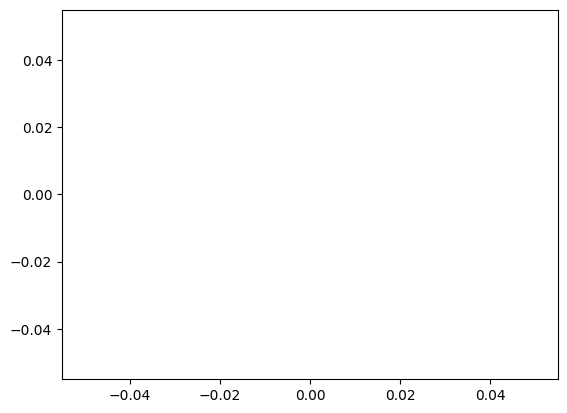

In [ ]:
loss_values = scores['loss']
plt.plot(range(len(loss_values)), [l.item() for l in loss_values])
plt.show()

# Saliency maps

### Interpretability technique functions

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ssl_model = models.resnet50(pretrained=False)
ssl_model.fc = torch.nn.Linear(2048, 128)

checkpoint = torch.load('/home/amy/brain_checkpoint_0099.pth.tar', map_location=torch.device('cpu'))
state_dict = checkpoint['state_dict']

state_dict = {key.replace('encoder_q.', ''): value for key, value in state_dict.items() if key.startswith('encoder_q')}

ssl_model.load_state_dict(state_dict)

def relu_hook_function(module, grad_in, grad_out):
    if isinstance(module, nn.ReLU):
        return (F.relu(grad_in[0]),)

def blur_sailency(input_image):
    return torchvision.transforms.functional.gaussian_blur(input_image, kernel_size=[11, 11], sigma=[5,5])

def sailency(guided, ssl_model, img1, img2, blur_output):

    measure = nn.CosineSimilarity(dim=-1)

    if guided:
        handles = []
        for i, module in enumerate(ssl_model.modules()):
            if isinstance(module, nn.ReLU):
                handles.append(module.register_backward_hook(relu_hook_function))

    input_image1 = img1.clone().requires_grad_()
    input_image2 = img2.clone().requires_grad_()
    score = measure(ssl_model(input_image1), ssl_model(input_image2))
    score.backward()
    grads1 = input_image1.grad.data
    grads2 = input_image2.grad.data
    sailency1, _ = torch.max((img1 * grads1).abs(), dim=1)
    sailency2, _ = torch.max((img2 * grads2).abs(), dim=1)

    if guided:     # remove handles after finishing
        for handle in handles:
            handle.remove()

    if blur_output:
        sailency1 = blur_sailency(sailency1)
        sailency2 = blur_sailency(sailency2)

    return sailency1, sailency2

def smooth_grad(guided, ssl_model, img1, img2, blur_output, steps = 50):

    measure = nn.CosineSimilarity(dim=-1)
    sigma = 0.15 / (torch.max(img1) - torch.min(img1)).item()

    if guided:
        handles = []
        for i, module in enumerate(ssl_model.modules()):
            if isinstance(module, nn.ReLU):
                handles.append(module.register_backward_hook(relu_hook_function))

    noise_images1 = []
    noise_images2 = []

    for _ in range(steps):
        noise = torch.zeros_like(img1).normal_(0, sigma)
        noise_images1.append(img1 + noise)
        noise_images2.append(img2 + noise)

    grads1 = []
    grads2 = []

    for n1, n2 in zip(noise_images1, noise_images2):

        ssl_model.zero_grad()
        input_image1 = n1.clone().requires_grad_()
        input_image2 = n2.clone().requires_grad_()

        if input_image1.grad is not None:
            input_image1.grad.data.zero_()
            input_image2.grad.data.zero_()

        score = measure(ssl_model(input_image1), ssl_model(input_image2))
        score.backward()
        grads1.append(input_image1.grad.data)
        grads2.append(input_image2.grad.data)

    grads1 = torch.cat(grads1).mean(0).unsqueeze(0)
    grads2 = torch.cat(grads2).mean(0).unsqueeze(0)
    sailency1, _ = torch.max((img1 * grads1 ).abs(), dim=1)
    sailency2, _ = torch.max((img2 * grads2).abs(), dim=1)

    if guided:     # remove handles after finishing
        for handle in handles:
            handle.remove()

    if blur_output:
        sailency1 = blur_sailency(sailency1)
        sailency2 = blur_sailency(sailency2)

    return sailency1, sailency2

def averaged_transforms(guided, ssl_model, mixed_images, blur_output):

    measure = nn.CosineSimilarity(dim=-1)

    if guided:
        handles = []
        for i, module in enumerate(ssl_model.modules()):
            if isinstance(module, nn.ReLU):
                handles.append(module.register_backward_hook(relu_hook_function))

    grads1 = []
    grads2 = []

    for xbar_image in mixed_images[1:]:

        ssl_model.zero_grad()
        input_image1 = mixed_images[0].clone().requires_grad_()
        input_image2 = xbar_image.clone().requires_grad_()

        if input_image1.grad is not None:
            input_image1.grad.data.zero_()
            input_image2.grad.data.zero_()

        score = measure(ssl_model(input_image1), ssl_model(input_image2))
        score.backward()
        grads1.append(input_image1.grad.data)
        grads2.append(input_image2.grad.data)

    grads1 = torch.cat(grads1).mean(0).unsqueeze(0)
    grads2 = torch.cat(grads2).mean(0).unsqueeze(0)

    sailency1, _ = torch.max((mixed_images[0] * grads1).abs(), dim=1)
    sailency2, _ = torch.max((mixed_images[-1] * grads2).abs(), dim=1)

    if guided:     # remove handles after finishing
        for handle in handles:
            handle.remove()

    if blur_output:
        sailency1 = blur_sailency(sailency1)
        sailency2 = blur_sailency(sailency2)

    return sailency1, sailency2

def show_image(x, squeeze = True, denormalize = False):

    if squeeze:
        x = x.squeeze(0)

    x = x.cpu().numpy().transpose((1, 2, 0))

    if denormalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        x = std * x + mean

    return x.clip(0, 1)

def occlusion(img1, img2, model, w_size = 64, stride = 8, batch_size = 32):

    measure = nn.CosineSimilarity(dim=-1)
    output_size = int(((img2.size(-1) - w_size) / stride) + 1)
    out1_condition, out2_condition = model(img1), model(img2)
    images1 = []
    images2 = []

    for i in range(output_size):
        for j in range(output_size):
            start_i, start_j = i * stride, j * stride
            image1 = img1.clone().detach()
            image2 = img2.clone().detach()
            image1[:, :, start_i : start_i + w_size, start_j : start_j + w_size] = 0
            image2[:, :, start_i : start_i + w_size, start_j : start_j + w_size] = 0
            images1.append(image1)
            images2.append(image2)

    images1 = torch.cat(images1, dim=0).to(device)
    images2 = torch.cat(images2, dim=0).to(device)

    score_map1 = []
    score_map2 = []

    assert images1.shape[0] == images2.shape[0]

    for b in range(0, images2.shape[0], batch_size):

        with torch.no_grad():
            out1 = model(images1[b : b + batch_size, :])
            out2 = model(images2[b : b + batch_size, :])

        score_map1.append(measure(out1, out2_condition))  # try torch.mm(out2_condition, out1.t())[0]
        score_map2.append(measure(out1_condition, out2))  # try torch.mm(out1_condition, out2.t())[0]

    score_map1 = torch.cat(score_map1, dim = 0)
    score_map2 = torch.cat(score_map2, dim = 0)
    assert images2.shape[0] == score_map2.shape[0] == score_map1.shape[0]

    heatmap1 = score_map1.view(output_size, output_size).cpu().detach().numpy()
    heatmap2 = score_map2.view(output_size, output_size).cpu().detach().numpy()
    base_score = measure(out1_condition, out2_condition)

    heatmap1 = (heatmap1 - base_score.item()) * -1   # or base_score.item() - heatmap1. The higher the drop, the better
    heatmap2 = (heatmap2 - base_score.item()) * -1   # or base_score.item() - heatmap2. The higher the drop, the better

    heatmap1 = (heatmap1 - heatmap1.min()) / (heatmap1.max() - heatmap1.min())
    heatmap2 = (heatmap2 - heatmap2.min()) / (heatmap2.max() - heatmap2.min())

    return heatmap1, heatmap2

def pairwise_occlusion(img1, img2, model, batch_size, erase_scale, erase_ratio, num_erases):

    measure = nn.CosineSimilarity(dim=-1)
    out1_condition, out2_condition = model(img1), model(img2)
    baseline = measure(out1_condition, out2_condition).detach()
    # a bit sensitive to scale and ratio. erase_scale is from (scale[0] * 100) % to (scale[1] * 100) %
    random_erase = transforms.RandomErasing(p=1.0, scale=erase_scale, ratio=erase_ratio)

    image1 = img1.clone().detach()
    image2 = img2.clone().detach()
    images1 = []
    images2 = []

    for _ in range(num_erases):
        images1.append(random_erase(image1))
        images2.append(random_erase(image2))

    images1 = torch.cat(images1, dim=0).to(device)
    images2 = torch.cat(images2, dim=0).to(device)

    sims = []
    weights1 = []
    weights2 = []

    for b in range(0, images2.shape[0], batch_size):

        with torch.no_grad():
            out1 = model(images1[b : b + batch_size, :])
            out2 = model(images2[b : b + batch_size, :])
            sims.append(measure(out1, out2))
            weights1.append(out1.norm(dim=-1))
            weights2.append(out2.norm(dim=-1))

    sims = torch.cat(sims, dim = 0)
    weights1, weights2 = torch.cat(weights1, dim = 0).cpu().numpy(), torch.cat(weights2, dim = 0).cpu().numpy()
    weights = list(zip(weights1, weights2))
    sims = baseline - sims   # the higher the drop, the better
    sims = F.softmax(sims, dim = -1)
    sims = sims.cpu().numpy()

    assert sims.shape[0] == images1.shape[0] == images2.shape[0]
    A1 = np.zeros((240, 240))
    A2 = np.zeros((240, 240))

    for n in range(images1.shape[0]):

        im1_2d = images1[n].cpu().numpy().transpose((1, 2, 0)).sum(axis=-1)
        im2_2d = images2[n].cpu().numpy().transpose((1, 2, 0)).sum(axis=-1)

        joint_similarity = sims[n]
        weight = weights[n]

        if weight[0] < weight[1]:
            A1[im1_2d == 0] += joint_similarity
        else:
            A2[im2_2d == 0] += joint_similarity

    A1 = A1 / (np.max(A1) + 1e-9)
    A2 = A2 / (np.max(A2) + 1e-9)

    return A1, A2

def overlay_heatmap(img, heatmap, denormalize=False):
    loaded_img = img.numpy().transpose((1, 2, 0))

    if denormalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        loaded_img = std * loaded_img + mean

    loaded_img = (loaded_img.clip(0, 1) * 255).astype(np.uint8)

    # Ensure heatmap is a 2D numpy array
    if isinstance(heatmap, np.ndarray) and heatmap.ndim == 0:  # Heatmap is a scalar
        heatmap = np.expand_dims(np.expand_dims(heatmap, axis=0), axis=0)  # Make it 2D

    cam = heatmap / np.max(heatmap)  # Normalize
    cam = cv2.resize(cam, (512, 512))  # Resize
    cam = np.uint8(255 * cam)
    cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)
    added_image = cv2.addWeighted(cam, 0.5, loaded_img, 0.5, 0)
    return added_image

def deprocess(inp, to_numpy = True, to_PIL = False, denormalize = False):

    if to_numpy:
        inp = inp.detach().cpu().numpy()

    inp = inp.squeeze(0).transpose((1, 2, 0))

    if denormalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean

    inp = (inp.clip(0, 1) * 255).astype(np.uint8)

    if to_PIL:
        return Image.fromarray(inp)
    return inp

class GradCAM(nn.Module):
    def __init__(self, model):
        super(GradCAM, self).__init__()
        self.model = model
        self.gradients = {}
        self.features = {}

        self.conv_layers = nn.Sequential(*list(model.children())[:-2])
        self.measure = nn.CosineSimilarity(dim=-1)

    def save_grads(self, img_index):
        def hook(grad):
            self.gradients[img_index] = grad.detach()
        return hook

    def save_features(self, img_index, feats):
        self.features[img_index] = feats.detach()

    def forward(self, img1, img2):
        features1 = self.conv_layers(img1)
        features2 = self.conv_layers(img2)

        self.save_features('1', features1)
        self.save_features('2', features2)

        h1 = features1.register_hook(self.save_grads('1'))
        h2 = features2.register_hook(self.save_grads('2'))

        out1 = self.model(img1)
        out2 = self.model(img2)

        score = self.measure(out1, out2)

        return score

def weight_activation(feats, grads):
    cam =  feats * F.relu(grads)
    cam = torch.sum(cam, dim=1).squeeze().cpu().detach().numpy()
    return cam

def get_gradcam(ssl_model, img1, img2):

    grad_cam = GradCAM(ssl_model).to(device)
    score = grad_cam(img1, img2)
    grad_cam.zero_grad()
    score.mean().backward()

    cam1 = weight_activation(grad_cam.features['1'], grad_cam.gradients['1'])
    cam2 = weight_activation(grad_cam.features['2'], grad_cam.gradients['2'])
    return cam1, cam2

def get_interactioncam(ssl_model, img1, img2, reduction, grad_interact = False):

    grad_cam = GradCAM(ssl_model).to(device)
    score = grad_cam(img1, img2)
    grad_cam.zero_grad()
    score.mean().backward()

    G1 = grad_cam.gradients['1']
    G2 = grad_cam.gradients['2']

    if grad_interact:
        B, D, H, W = G1.size()
        G1_ = G1.permute(0,2,3,1).view(B, H * W, D)
        G2_ = G2.permute(0,2,3,1).view(B, H * W, D)
        G_ = torch.bmm(G1_.permute(0,2,1), G2_)  # (B, D, D)
        G1, _ = torch.max(G_, dim = -1)   # (B, D)
        G2, _ = torch.max(G_, dim = 1)    # (B, D)
        G1 = G1.unsqueeze(-1).unsqueeze(-1)
        G2 = G2.unsqueeze(-1).unsqueeze(-1)

    if reduction == 'mean':
        joint_weight = grad_cam.features['1'].mean([2,3]) * grad_cam.features['2'].mean([2,3])
    elif reduction == 'max':
        max_pooled1 = F.max_pool2d(grad_cam.features['1'], kernel_size=grad_cam.features['1'].size()[2:]).squeeze(-1).squeeze(-1)
        max_pooled2 = F.max_pool2d(grad_cam.features['2'], kernel_size=grad_cam.features['2'].size()[2:]).squeeze(-1).squeeze(-1)
        joint_weight = max_pooled1 * max_pooled2
    else:
        B, D, H, W = grad_cam.features['1'].size()
        reshaped1 = grad_cam.features['1'].permute(0,2,3,1).reshape(B, H * W, D)
        reshaped2 = grad_cam.features['2'].permute(0,2,3,1).reshape(B, H * W, D)
        features1_query, features2_query = reshaped1.mean(1).unsqueeze(1), reshaped2.mean(1).unsqueeze(1)
        attn1 = (features1_query @ reshaped1.transpose(-2, -1)).softmax(dim=-1)
        attn2 = (features2_query @ reshaped2.transpose(-2, -1)).softmax(dim=-1)
        att_reduced1 = (attn1 @ reshaped1).squeeze(1)
        att_reduced2 = (attn2 @ reshaped2).squeeze(1)
        joint_weight = att_reduced1 * att_reduced2

    joint_weight = joint_weight.unsqueeze(-1).unsqueeze(-1).expand_as(grad_cam.features['1'])

    feats1 = grad_cam.features['1'] * joint_weight
    feats2 = grad_cam.features['2'] * joint_weight

    cam1 = weight_activation(feats1, G1)
    cam2 = weight_activation(feats2, G2)

    return cam1, cam2

### BraTS dataset

In [ ]:
transform = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.RandomApply([transforms.RandomResizedCrop(size=(240, 240), scale=(0.8, 1.0))], p=0.3),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.5),
    transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.3),
    transforms.RandomApply([transforms.RandomVerticalFlip()], p=0.3),
    transforms.RandomApply([transforms.RandomRotation(degrees=(0, 360))], p=0.3),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=10)], p=0.3),
    transforms.ToTensor()
])

train_dataset = BraTSDataset('/home/amy/brains')

img1 = train_dataset[0][0]
plt.imshow(img1[1])
plt.show()

img2 = transforms.functional.rotate(train_dataset[0][0], 160)
plt.imshow(img2[1])
plt.show()

In [ ]:
epsilon=1e-6

dataset = BraTSDataset('/home/amy/brains')

loader = DataLoader(
    [dataset[i] for i in range(0, 74)],
    batch_size=1,
    num_workers=0,
    shuffle=True
)

dice_scores_file = '/home/amy/brain_dice_scores_1.txt'

with open(dice_scores_file, 'a') as file:
    for i in range(0, 360):
        for _, (image, mask) in enumerate(tqdm(loader, desc=f"Processing rotation {i}")):

            img1 = image[0][0].cuda()
            img2 = transforms.functional.rotate(image[0], i).cuda()
            true_mask = mask[0][0].cuda()

            sailency1_s, sailency2_s = smooth_grad(guided = True, ssl_model = ssl_model.cuda(),
                                                  img1 = image[0].unsqueeze(0).cuda(), img2 = img2.unsqueeze(0).cuda(),
                                                  blur_output = True, steps = 50)

            saliency2_s = transforms.functional.rotate(sailency2_s, -i).cuda()

            saliency2_np = sailency2_s.cpu().detach().numpy()
            true_mask_np = true_mask.cpu().detach().numpy()

            binary_saliency = (saliency2_np[0] > 0).astype(int)
            binary_mask = (true_mask_np > 0).astype(int)

            intersection = np.logical_and(binary_saliency, binary_mask).sum()
            union = binary_saliency.sum() + binary_mask.sum()
            dice = 2 * intersection / (union + intersection + 1e-6)
            file.write(f'{i}, {dice.item()}\n')


In [ ]:
import matplotlib.pyplot as plt

averages = []

dice_scores_file = '/home/amy/brain_dice_scores_1.txt'

i = 0
count = 0

with open(dice_scores_file, 'r') as file:
    for line in file:
        l = line.split(', ')
        if (int(l[0]) == i):
            count += float(l[1][:-2])
        else:
            averages.append(count/75)
            count = 0
            count += float(l[1][:-2])
            i += 1
print(averages)


plt.plot(range(len(averages)), averages)
plt.xlabel('Rotation (Degrees)')
plt.ylabel('Dice Score')
plt.title('BraTS Dice Score vs Rotation')
plt.show()

print(min(averages), max(averages))

import numpy as np
from scipy.signal import argrelextrema
from scipy.signal import find_peaks

#argrelextrema(np.array(averages), np.greater)
#argrelextrema(np.array(averages), np.less)

peaks, _ = find_peaks(averages, height=0)
print(peaks)

argrelextrema(np.array(averages), np.less)

### Lung dataset

In [ ]:
transform = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.RandomApply([transforms.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0))], p=0.3),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.5),
    transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.3),
    transforms.RandomApply([transforms.RandomVerticalFlip()], p=0.3),
    transforms.RandomApply([transforms.RandomRotation(degrees=(0, 360))], p=0.3),
    #transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=10)], p=0.3),
    transforms.ToTensor()
])

train_dataset = ChestXrayDataset('/home/amy/train')

img1 = train_dataset[0][0]
plt.imshow(img1[0])
plt.show()

img2 = transforms.functional.rotate(train_dataset[0][0], 160)
plt.imshow(img2[0])
plt.show()

In [ ]:
epsilon=1e-6

dataset = ChestXrayDataset('/home/amy/train')

loader = DataLoader(
    [dataset[i] for i in range(0, 75)],
    batch_size=1,
    num_workers=0,
    shuffle=True
)

dice_scores_file = '/home/amy/chest_dice_scores_zoomed.txt'

degrees = [i for i in range(0, 360) if i % 2 == 0 or i in [45, 135, 225, 315]]

with open(dice_scores_file, 'a') as file:
    for i in degrees:
        for _, (image, mask) in enumerate(tqdm(loader, desc=f"Processing rotation {i}")):

            img1 = transforms.functional.crop(image[0], 75, 75, 362, 362)
            img2 = transforms.functional.crop(transforms.functional.rotate(image[0], i), 75, 75, 362, 362).cuda()
            true_mask = transforms.functional.crop(mask[0][0], 75, 75, 362, 362).cuda()

            sailency1_s, sailency2_s = smooth_grad(guided = True, ssl_model = ssl_model.cuda(),
                                                  img1 = img1.unsqueeze(0).cuda(), img2 = img2.unsqueeze(0).cuda(),
                                                  blur_output = True, steps = 50)

            saliency2_s_ = transforms.functional.rotate(sailency2_s, -i).cuda()

            saliency2_np = saliency2_s_.cpu().detach().numpy()
            true_mask_np = true_mask.cpu().detach().numpy()

            binary_saliency = (saliency2_np[0] > 0).astype(int)
            binary_mask = (true_mask_np > 0).astype(int)

            intersection = np.logical_and(binary_saliency, binary_mask).sum()
            union = binary_saliency.sum() + binary_mask.sum()
            dice = 2 * intersection / (union + intersection + 1e-6)

            file.write(f'{i}, {dice.item()}\n')


In [ ]:
import matplotlib.pyplot as plt

averages = []

dice_scores_file = '/home/amy/chest_dice_scores_zoomed.txt'

i = 0
count = 0

with open(dice_scores_file, 'r') as file:
    for line in file:
        l = line.split(', ')
        if (int(l[0]) == i):
            count += float(l[1][:-2])
        else:
            averages.append(count/20)
            print(i, count)
            count = 0
            count += float(l[1][:-2])
            if (i in [44, 45, 134, 135, 224, 225, 314, 315]):
                i += 1
            else:
                i += 2
print(averages)


plt.plot(range(len(averages)), averages)
plt.xlabel('Rotation (Degrees)')
plt.ylabel('Dice Score')
plt.title('Lung Mask Image Dice Score vs Rotation')
plt.show()

print(min(averages), max(averages))

import numpy as np
from scipy.signal import argrelextrema
from scipy.signal import find_peaks

#argrelextrema(np.array(averages), np.greater)
#argrelextrema(np.array(averages), np.less)

peaks, _ = find_peaks(averages, height=0)
print(peaks)

argrelextrema(np.array(averages), np.less)

### Kvasir-SEG dataset

In [ ]:
transform = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.RandomApply([transforms.RandomResizedCrop(size=(412, 412), scale=(0.8, 1.0))], p=0.3),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.5),
    transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.3),
    transforms.RandomApply([transforms.RandomVerticalFlip()], p=0.3),
    transforms.RandomApply([transforms.RandomRotation(degrees=(0, 360))], p=0.3),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=10)], p=0.3),
    transforms.ToTensor()
])

train_dataset = GIDataset('/home/amy/Kvasir-SEG')

img1 = transforms.functional.crop(train_dataset[0][0], 50, 50, 412, 412)
plt.imshow(img1[0])
plt.show()

img2 = transforms.functional.crop(transforms.functional.rotate(train_dataset[0][0], 160), 50, 50, 412, 412)
plt.imshow(img2[0])
plt.show()

In [ ]:
epsilon=1e-6

dataset = GIDataset('/home/amy/Kvasir-SEG')

loader = DataLoader(
    [dataset[i] for i in range(0, 75)],
    batch_size=1,
    num_workers=0,
    shuffle=True
)

dice_scores_file = '/home/amy/gi_dice_scores_zoomed.txt'

degrees = [i for i in range(0, 360) if i % 2 == 0 or i in [45, 135, 225, 315]]

with open(dice_scores_file, 'a') as file:
    for i in degrees:
        for _, (image, mask) in enumerate(tqdm(loader, desc=f"Processing rotation {i}")):

            img1 = transforms.functional.crop(image[0], 75, 75, 362, 362)
            img2 = transforms.functional.crop(transforms.functional.rotate(image[0], i), 75, 75, 362, 362).cuda()
            true_mask = transforms.functional.crop(mask[0][0], 75, 75, 362, 362).cuda()

            sailency1_s, sailency2_s = smooth_grad(guided = True, ssl_model = ssl_model.cuda(),
                                                  img1 = img1.unsqueeze(0).cuda(), img2 = img2.unsqueeze(0).cuda(),
                                                  blur_output = True, steps = 50)

            saliency2_s_ = transforms.functional.rotate(sailency2_s, -i).cuda()

            saliency2_np = saliency2_s_.cpu().detach().numpy()
            true_mask_np = true_mask.cpu().detach().numpy()

            binary_saliency = (saliency2_np[0] > 0).astype(int)
            binary_mask = (true_mask_np > 0).astype(int)

            intersection = np.logical_and(binary_saliency, binary_mask).sum()
            union = binary_saliency.sum() + binary_mask.sum()
            dice = 2 * intersection / (union + intersection + 1e-6)

            file.write(f'{i}, {dice.item()}\n')


In [ ]:
import matplotlib.pyplot as plt

averages = []

dice_scores_file = '/home/amy/gi_dice_scores_zoomed.txt'

i = 0
count = 0

with open(dice_scores_file, 'r') as file:
    for line in file:
        l = line.split(', ')
        if (int(l[0]) == i):
            count += float(l[1][:-2])
        else:
            averages.append(count/20)
            print(i, count)
            count = 0
            count += float(l[1][:-2])
            if (i in [44, 45, 134, 135, 224, 225, 314, 315]):
                i += 1
            else:
                i += 2
print(averages)


plt.plot(range(len(averages)), averages)
plt.xlabel('Rotation (Degrees)')
plt.ylabel('Dice Score')
plt.title('Kvasir-SEG Dice Score vs Rotation')
plt.show()

print(min(averages), max(averages))

import numpy as np
from scipy.signal import argrelextrema
from scipy.signal import find_peaks

#argrelextrema(np.array(averages), np.greater)
#argrelextrema(np.array(averages), np.less)

peaks, _ = find_peaks(averages, height=0)
print(peaks)

argrelextrema(np.array(averages), np.less)

# SVM classifier

### Plot HOG

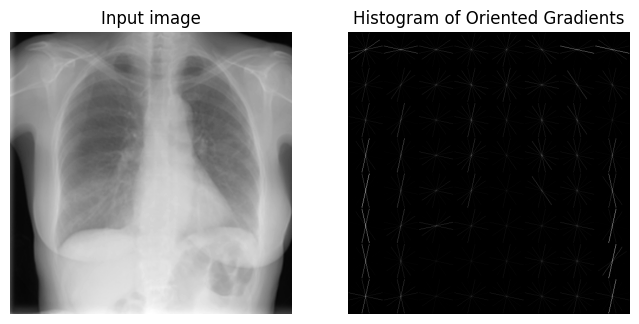

In [ ]:
from skimage.feature import hog
from skimage import data, exposure

#dataset = BraTSDataset('/content/drive/MyDrive/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData')

image = np.array(Image.open('/content/drive/MyDrive/cxrimage_0.png'))[:,:,0]

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(64, 64),
                    cells_per_block=(1, 1), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.savefig("brats_hog.pdf", format="pdf", bbox_inches="tight")
plt.show()

### BraTS dataset

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage.feature import hog
from skimage import color

file = '/home/amy/svm_accuracies.txt'

X = []
y = []

for filename in os.listdir('/home/amy/brains/images')[0:75]:
    image = Image.open('/home/amy/brains/images/' + filename).convert('L')
    image_np = np.array(image)

    hog_features, _ = hog(image_np, pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys', visualize=True)
    X.append(hog_features)

    rotated_image = image.rotate(np.random.randint(1, 359))
    rotated_image_np = np.array(rotated_image)

    rotated_hog_features, _ = hog(rotated_image_np, pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys', visualize=True)
    X.append(rotated_hog_features)

    y.extend([0, 1])

X = np.array(X)
X_flattened = X.reshape(X.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

param_grid = {'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.008, 0.03, 0.07],
        'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0)
grid.fit(X_train, y_train)

best_svc = grid.best_estimator_
best_svc.fit(X_train, y_train)

original_images = []
for filename in os.listdir('/home/amy/brains/images')[75:150]:
    image = Image.open(f'/home/amy/brains/images/{filename}').convert('L')
    original_images.append(np.array(image))

results = []
for angle in tqdm(range(360)):
    X_test, y_test = [], []
    for image_np in original_images:

        hog_features, _ = hog(image_np, pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys', visualize=True)
        X_test.append(hog_features)
        y_test.append(0)

        rotated_image = Image.fromarray(image_np).rotate(angle)
        rotated_image_np = np.array(rotated_image)

        rotated_hog_features, _ = hog(rotated_image_np, pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys', visualize=True)
        X_test.append(rotated_hog_features)
        y_test.append(1)

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    predictions = best_svc.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results.append((angle, accuracy))

with open('/home/amy/svm_accuracies.txt', 'w') as file:
    for angle, accuracy in results:
        file.write(f'{angle}, {accuracy}\n')

In [ ]:
accuracies = []
dice_scores_file = '/home/amy/svm_accuracies.txt'

with open(dice_scores_file, 'r') as file:
    for line in file:
        l = line.split(', ')
        accuracies.append(float(l[1][:5]))
print(accuracies)

plt.plot(range(len(accuracies)), accuracies)
plt.xlabel('Rotation (Degrees)')
plt.ylabel('Accuracy')
plt.title('BraTS SVM Accuracy')
plt.savefig("brats_svm.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Lung dataset

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage.feature import hog
from skimage import color

file = '/home/amy/gi_svm_accuracies.txt'

X = []
y = []

for filename in os.listdir('/home/amy/train/image')[0:75]:
    if filename[-3:] == 'png':
        image = Image.open('/home/amy/train/image/' + filename).convert('L')
        image_np = np.array(image)

        hog_features, _ = hog(image_np, pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys', visualize=True)
        X.append(hog_features)

        rotated_image = image.rotate(np.random.randint(1, 359))
        rotated_image_np = np.array(rotated_image)

        rotated_hog_features, _ = hog(rotated_image_np, pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys', visualize=True)
        X.append(rotated_hog_features)

        y.extend([0, 1])

X = np.array(X)
X_flattened = X.reshape(X.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

param_grid = {'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.008, 0.03, 0.07],
        'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0)
grid.fit(X_train, y_train)

best_svc = grid.best_estimator_
best_svc.fit(X_train, y_train)

original_images = []
for filename in os.listdir('/home/amy/train/image')[75:150]:
    image = Image.open(f'/home/amy/train/image/{filename}').convert('L')
    original_images.append(np.array(image))

results = []
for angle in tqdm(range(360)):
    X_test, y_test = [], []
    for image_np in original_images:

        hog_features, _ = hog(image_np, pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys', visualize=True)
        X_test.append(hog_features)
        y_test.append(0)

        rotated_image = Image.fromarray(image_np).rotate(angle)
        rotated_image_np = np.array(rotated_image)

        rotated_hog_features, _ = hog(rotated_image_np, pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys', visualize=True)
        X_test.append(rotated_hog_features)
        y_test.append(1)

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    predictions = best_svc.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results.append((angle, accuracy))

with open('/home/amy/lung_svm_accuracies.txt', 'w') as file:
    for angle, accuracy in results:
        file.write(f'{angle}, {accuracy}\n')

In [ ]:
accuracies = []
dice_scores_file = '/home/amy/lung_svm_accuracies.txt'

with open(dice_scores_file, 'r') as file:
    for line in file:
        l = line.split(', ')
        accuracies.append(float(l[1][:5]))
print(accuracies)

plt.plot(range(len(accuracies)), accuracies)
plt.xlabel('Rotation (Degrees)')
plt.ylabel('Accuracy')
plt.title('Lung Mask Image SVM Accuracy')
plt.savefig("lungs_svm.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Kvasir-SEG dataset

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage.feature import hog
from skimage import color

file = '/home/amy/gi_svm_accuracies.txt'

X = []
y = []

for filename in os.listdir('/home/amy/Kvasir-SEG/images')[0:75]:
    image = Image.open('/home/amy/Kvasir-SEG/images/' + filename).convert('L')
    image_np = np.array(image)

    hog_features, _ = hog(image_np, pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys', visualize=True)
    X.append(hog_features)

    rotated_image = image.rotate(np.random.randint(1, 359))
    rotated_image_np = np.array(rotated_image)

    rotated_hog_features, _ = hog(rotated_image_np, pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys', visualize=True)
    X.append(rotated_hog_features)

    y.extend([0, 1])

X = np.array(X)
X_flattened = X.reshape(X.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

param_grid = {'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.008, 0.03, 0.07],
        'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0)
grid.fit(X_train, y_train)

best_svc = grid.best_estimator_
best_svc.fit(X_train, y_train)

original_images = []
for filename in os.listdir('/home/amy/Kvasir-SEG/images')[75:150]:
    image = Image.open(f'/home/amy/Kvasir-SEG/images/{filename}').convert('L')
    original_images.append(np.array(image))

results = []
for angle in tqdm(range(360)):
    X_test, y_test = [], []
    for image_np in original_images:

        hog_features, _ = hog(image_np, pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys', visualize=True)
        X_test.append(hog_features)
        y_test.append(0)

        rotated_image = Image.fromarray(image_np).rotate(angle)
        rotated_image_np = np.array(rotated_image)

        rotated_hog_features, _ = hog(rotated_image_np, pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys', visualize=True)
        X_test.append(rotated_hog_features)
        y_test.append(1)

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    predictions = best_svc.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results.append((angle, accuracy))

with open('/home/amy/gi_svm_accuracies.txt', 'w') as file:
    for angle, accuracy in results:
        file.write(f'{angle}, {accuracy}\n')

In [ ]:
accuracies = []
dice_scores_file = '/home/amy/gi_svm_accuracies.txt'

with open(dice_scores_file, 'r') as file:
    for line in file:
        l = line.split(', ')
        accuracies.append(float(l[1][:5]))
print(accuracies)

plt.plot(range(len(accuracies)), accuracies)
plt.xlabel('Rotation (Degrees)')
plt.ylabel('Accuracy')
plt.title('Kvasir-SEG SVM Accuracy')
plt.savefig("gi_svm.pdf", format="pdf", bbox_inches="tight")
plt.show()